### TransUnet

In [34]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from self_attention_cv.transunet import TransUnet

import numpy as np
import einops

import matplotlib.pyplot as plt
from PIL import Image

import os
import fnmatch
import ntpath
import random

import seaborn as sns

In [35]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [36]:
def collect_paths(treeroot, pattern):
    results = []
    for base, _, files in os.walk(treeroot):
        goodfiles = fnmatch.filter(files, pattern)
        results.extend(os.path.join(base, f) for f in goodfiles)

    return sorted(results)

def get_train_test_idxs(paths, coeff=0.95) -> (list, list):
    amount = round(len(paths) * train_subset_coeff)
    idxs = list(range(len(paths)))
    random.shuffle(idxs)
    
    return idxs[:amount], idxs[amount:]

class MinMaxNormalize:
    """Implementation of min-max normalization.
    """
    def __call__(self, sample):
        assert isinstance(sample, (torch.Tensor, np.ndarray)), "arg must be a torch.Tensor or np.ndarray"

        return (sample - sample.min()) / (sample.max() - sample.min())


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    MinMaxNormalize()
])


class XRayRenderSet(Dataset):
    def __init__(self, mask_paths, image_paths, transform):
        self.mask_paths = mask_paths
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.mask_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        original_image = MinMaxNormalize()( transforms.ToTensor()( image ) )
        image = self.transform(image)
        image = image.type(torch.float32)
        
        mask = Image.open(self.mask_paths[idx])
        mask = self.transform(mask)
        mask = mask.type(torch.float32)
        
        return original_image, image, mask


class XRaySet(Dataset):
    def __init__(self, mask_paths, image_paths, transform):
        self.mask_paths = mask_paths
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.mask_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = self.transform(image)
        image = image.type(torch.float32)
        
        mask = Image.open(self.mask_paths[idx])
        mask = self.transform(mask)
        mask = mask.type(torch.float32)
        
        return image, mask
    
def show(x):
    x = einops.rearrange(
        x,
        "b c h w -> (b c h) w"
    )

    x = (x.cpu().detach().numpy() * 255).astype(np.uint8)
    
    return x

def intensity(image, bool_mask, values):
    """ Highlights the masked part of the image
    """
    image = np.stack([image, image, image], axis=2)
    
    if isinstance(values, int):
        values = (values, values, values)

    for ind,v in enumerate(values):
        channel = np.where(~bool_mask, image[:, :, ind], image[:, :, ind] - v)
        channel[channel<0] = 0
        image[:, :, ind] = channel.astype(int)

    return image

In [37]:
batch_size = 1

img_path = "company_target_images/"
mask_path = "company_target_jsons/"

img_paths = collect_paths(img_path, "*.png")
mask_paths = collect_paths(mask_path, "*.png")

# Cut masks with has no corresponding images
names = [ntpath.split(i)[1] for i in img_paths]
mask_paths = [i for i in mask_paths if ntpath.split(i)[1] in names]

# Cut imgs with has no corresponding masks
names = [ntpath.split(i)[1] for i in mask_paths]
img_paths = [i for i in img_paths if ntpath.split(i)[1] in names]

test_idxs = list(range(len(names)))

In [38]:
print(f"{len(img_paths)}, {len(mask_paths)}")

57, 57


In [39]:
print(f"{len(test_idxs)}")

57


In [40]:
test_image_paths = [img_paths[ind] for ind in test_idxs]
test_mask_paths  = [mask_paths[ind] for ind in test_idxs]

test_dataset = XRaySet(image_paths=test_image_paths, mask_paths=test_mask_paths, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [29]:
def jaccard_loss(true, logits, eps=1e-7):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the jaccard loss so we
    return the negated jaccard loss.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        jacc_loss: the Jaccard loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    union = cardinality - intersection
    jacc_loss = (intersection / (union + eps)).mean()
    return (1 - jacc_loss)

def tversky_loss(true, logits, alpha=0.5, beta=0.5, eps=1e-7):
    """Computes the Tversky loss [1].
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        alpha: controls the penalty for false positives.
        beta: controls the penalty for false negatives.
        eps: added to the denominator for numerical stability.
    Returns:
        tversky_loss: the Tversky loss.
    Notes:
        alpha = beta = 0.5 => dice coeff
        alpha = beta = 1 => tanimoto coeff
        alpha + beta = 1 => F beta coeff
    References:
        [1]: https://arxiv.org/abs/1706.05721
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    fps = torch.sum(probas * (1 - true_1_hot), dims)
    fns = torch.sum((1 - probas) * true_1_hot, dims)
    num = intersection
    denom = intersection + (alpha * fps) + (beta * fns)
    tversky_loss = (num / (denom + eps)).mean()
    return (1 - tversky_loss)

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [30]:
model = TransUnet(
    in_channels=1,
    img_dim=256,
    vit_blocks=8,  # было 8
    vit_dim_linear_mhsa_block=512,
    classes=1
)

model = model.cpu() #.cuda()

In [32]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print("Trainable parameters amount: {:n}".format(params))

Trainable parameters amount: 67076987


In [33]:
# lr: from 0.01 to 0.00015625 in 10,000 epoches
# optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1700, gamma=0.5)

criterion = torch.nn.BCELoss()
# criterion = DiceLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10_000  # ~36s на эпоху -> 100 часов -> 4 дня

verbose = 1
save_step = 10

In [278]:
# t_output.mean(), t_output.max(), t_output.min(), torch.quantile(t_output.flatten(), torch.tensor([0.01]).cuda())

In [168]:
with open("test_idxs.txt", "w") as file:
    file.write(" ".join(map(str, test_idxs)))

In [279]:
%%time
losses = []
for epoch in range(num_epochs):
    loss_accumulator = []
    
    for ind,data in enumerate(train_dataloader):
        images, masks = data
        masks = (masks==0).type(torch.float32)
        images = images.cuda()
        masks = masks.cuda()
        
        output = model(images)
        output = torch.sigmoid(output)
        
        optimizer.zero_grad()
        
        # Don't forget about -1 if you are using SSIM-like losses!
        loss = criterion(output, masks)
        diff = loss.item()
        
        loss.backward()
        optimizer.step()
        # scheduler.step()       
        loss_accumulator.append(diff)
        
    losses.append(np.mean(loss_accumulator))
        
    if (epoch + 1) % save_step == 0:
        torch.save(model.state_dict(), f"transunet_{epoch+1}epo_bce_vit8.meow")
           
    print('epoch [{}/{}], loss: {:.5f}'.format(epoch+1, num_epochs, np.mean(loss_accumulator)))
    
    # with open("losses.txt", "a+") as file:
    #     file.write('epoch [{}/{}], loss: {:.5f}\n'.format(epoch+1, num_epochs, np.mean(loss_accumulator)))

epoch [1/10000], loss: 0.43306
epoch [2/10000], loss: 0.37802
epoch [3/10000], loss: 0.36545
epoch [4/10000], loss: 0.33717
epoch [5/10000], loss: 0.33283
epoch [6/10000], loss: 0.32022
epoch [7/10000], loss: 0.30437
epoch [8/10000], loss: 0.29001
epoch [9/10000], loss: 0.27708
epoch [10/10000], loss: 0.26071
epoch [11/10000], loss: 0.26317
epoch [12/10000], loss: 0.22908
epoch [13/10000], loss: 0.24300
epoch [14/10000], loss: 0.21124
epoch [15/10000], loss: 0.21820
epoch [16/10000], loss: 0.19167
epoch [17/10000], loss: 0.17976
epoch [18/10000], loss: 0.16742
epoch [19/10000], loss: 0.16676
epoch [20/10000], loss: 0.15132
epoch [21/10000], loss: 0.14838
epoch [22/10000], loss: 0.14498
epoch [23/10000], loss: 0.14099
epoch [24/10000], loss: 0.13786
epoch [25/10000], loss: 0.11938
epoch [26/10000], loss: 0.11636
epoch [27/10000], loss: 0.08790
epoch [28/10000], loss: 0.11079
epoch [29/10000], loss: 0.10182
epoch [30/10000], loss: 0.09210
epoch [31/10000], loss: 0.08193
epoch [32/10000],

KeyboardInterrupt: 

In [359]:
for ind, data in enumerate(test_dataloader):
    original, t_images, t_masks = data
    t_images = t_images.cuda()
    t_masks = t_masks.cuda()

    t_output = model(t_images)
    t_output = torch.sigmoid(t_output)
    
    threshold = torch.quantile(t_output.flatten(), torch.tensor([0.01]).cuda())
    t_output = (t_output > threshold).type(torch.float32)
        
    
    if ind % 15 == 0 and ind != 0:
        break

In [12]:
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

def tr(x):
    return min_max(x) * 255

In [19]:
def analyze(source):
    if type(source) == str:
        me_arr = Image.open(source).convert('L')
        me_arr = transform(me_arr).cpu()
        me_arr = me_arr.type(torch.float32)

        me_arr = einops.rearrange(me_arr, "(b c) h w -> b c h w", b=1)
    else:
        arr, me_arr, mask = source
        
        # print(arr.shape)

        # t_output = model(arr)
        # t_output = torch.sigmoid(t_output)
        # t_output = show(t_output)
        
        
    
    me_output = model(me_arr.cpu())
    me_output = torch.sigmoid(me_output)
    
    me_output = show(me_output)
    me_output = me_output < 55 # model.load_state_dict(torch.load(PATH))# me_output.mean()
    
    if type(source) == str:
        me_output_mask = transforms.Resize(Image.open(source).size[::-1])(Image.fromarray(me_output))
        
        return Image.fromarray(
            intensity(
                (MinMaxNormalize()(np.array(Image.open(source).convert("L"))) * 255).astype(np.uint8),
                np.array(me_output_mask), (20, 20, 0)
            )
        )
    else:
        me_output_mask = me_output #transforms.Resize(source.shape)(Image.fromarray(me_output))
        me_output_mask = transforms.Resize(arr.shape[-2:])(Image.fromarray(me_output_mask))
        mask = transforms.Resize(arr.shape[-2:])(Image.fromarray(mask.numpy()[0, 0, :]))
        
        # return 
        
        tmp = (MinMaxNormalize()(arr) * 255).numpy().astype(np.uint8)[0, ]
        tmp = g_to_rgb(tmp)[0, :]
        tmp = einops.rearrange(tmp, "c h w -> h w c")
            
        # tmp = intensity(
        #         (MinMaxNormalize()(arr) * 255).numpy().astype(np.uint8),
        #         np.array(me_output_mask), (120, 120, 0)
        #     )[0, 0, :, :, :] #.astype(np.uint8)
            
        # tmp = Image.fromarray(einops.rearrange(tmp, "c h w -> h w c"))
        
        # img = g_to_rgb(torch.from_numpy(show(t_images)))
        # msk = me_output_mask == 255
        
        msk = transforms.ToTensor()(me_output_mask) != 0.
        msk_original = transforms.ToTensor()(mask) != 0.

        r = dsm(image=(transforms.ToTensor()(tmp)*255).type(torch.uint8), masks=msk, alpha=0.5, colors="#20a7c8").numpy()
        r = einops.rearrange(r, "c h w -> h w c")
        r = Image.fromarray(r).convert('RGB')
                
        return r, me_output_mask, arr, msk_original[0, :], msk[0, :]

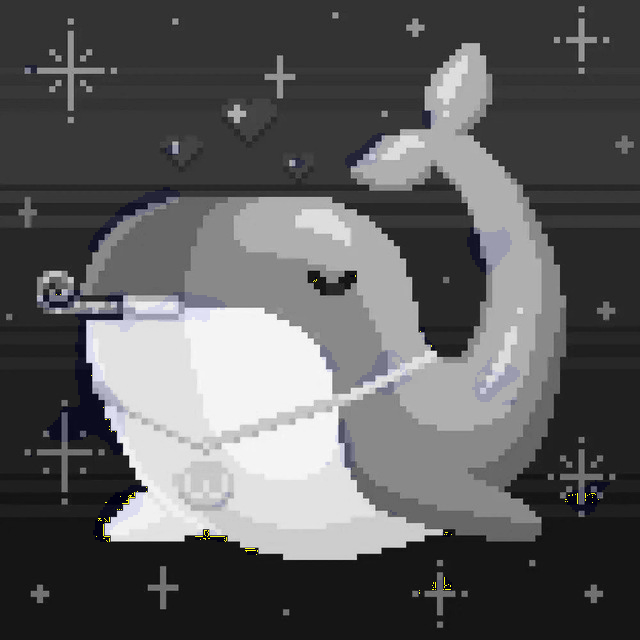

In [24]:
analyze('/home/student/Documents/xrays/avatar105858661-0.jpg') #.save("example_4.png")

In [483]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, sigma, channel):
    _1D_window = gaussian(window_size, sigma).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

class MS_SSIM(torch.nn.Module):
    def __init__(self, size_average = True, max_val = 255):
        super(MS_SSIM, self).__init__()
        self.size_average = size_average
        self.channel = 1
        self.max_val = max_val
    def _ssim(self, img1, img2, size_average = True):

        _, c, w, h = img1.size()
        window_size = min(w, h, 11)
        sigma = 1.5 * window_size / 11
        window = create_window(window_size, sigma, self.channel).cuda()
        mu1 = F.conv2d(img1, window, padding = window_size//2, groups = self.channel)
        mu2 = F.conv2d(img2, window, padding = window_size//2, groups = self.channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1*mu2

        sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = self.channel) - mu1_sq
        sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = self.channel) - mu2_sq
        sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = self.channel) - mu1_mu2

        C1 = (0.01*self.max_val)**2
        C2 = (0.03*self.max_val)**2
        V1 = 2.0 * sigma12 + C2
        V2 = sigma1_sq + sigma2_sq + C2
        ssim_map = ((2*mu1_mu2 + C1)*V1)/((mu1_sq + mu2_sq + C1)*V2)
        mcs_map = V1 / V2
        if size_average:
            return ssim_map.mean(), mcs_map.mean()

    def ms_ssim(self, img1, img2, levels=5):

        weight = Variable(torch.Tensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).cuda())

        msssim = Variable(torch.Tensor(levels,).cuda())
        mcs = Variable(torch.Tensor(levels,).cuda())
        for i in range(levels):
            ssim_map, mcs_map = self._ssim(img1, img2)
            msssim[i] = ssim_map
            mcs[i] = mcs_map
            filtered_im1 = F.avg_pool2d(img1, kernel_size=2, stride=2)
            filtered_im2 = F.avg_pool2d(img2, kernel_size=2, stride=2)
            img1 = filtered_im1
            img2 = filtered_im2

        value = (torch.prod(mcs[0:levels-1]**weight[0:levels-1])*
                                    (msssim[levels-1]**weight[levels-1]))
        return value


    def forward(self, img1, img2):

        return self.ms_ssim(img1, img2)
    

ms_ssim = MS_SSIM()
ms_ssim = ms_ssim.cuda()

In [486]:
test_losses = {"mean": [], "min": 1, "max": 0}
test_losses_2 = {"mean": [], "min": 1, "max": 0}
for ind, data in enumerate(render_dataloader):
#     original, t_images, t_masks = data
#     t_images = t_images.cuda()
#     t_masks = t_masks.cuda()
#     t_output = model(t_images)
#     t_output = torch.sigmoid(t_output)
#     threshold = torch.quantile(t_output.flatten(), torch.tensor([0.01]).cuda())
#     t_output = (t_output > threshold).type(torch.float32)
        
#     if ind % 120 == 0 and ind != 0:
#         break

    test_loss = IoU(analyze(data)[3], analyze(data)[4]).item()
    test_losses["mean"].append(test_loss)
    if test_losses["min"] >= test_loss:
        test_losses["min"] = test_loss
    if test_losses["max"] <= test_loss:
        test_losses["max"] = test_loss
        
    a = ms_ssim(einops.rearrange(analyze(data)[3], "(b c h) w -> b c h w", b=1, c=1).cuda()*1., einops.rearrange(analyze(data)[4].cpu(), "(b c h) w -> b c h w", b=1, c=1).cuda()*1.) #.item()
    a = a.item()
    test_losses_2["mean"].append(a)
    if test_losses_2["min"] >= a:
        test_losses_2["min"] = a
    if test_losses_2["max"] <= a:
        test_losses_2["max"] = a
        
test_losses_2["mean"] = np.mean(test_losses_2["mean"])
test_losses["mean"] = np.mean(test_losses["mean"])

In [488]:
print(f'IOU    : {test_losses["mean"]=}, {test_losses["min"]=}, {test_losses["max"]=}')
print(f'MS-SSIM: {test_losses_2["mean"]=}, {test_losses_2["min"]=}, {test_losses_2["max"]=}')

IOU    : test_losses["mean"]=0.431868798464374, test_losses["min"]=1.389274806307128e-10, test_losses["max"]=1.0
MS-SSIM: test_losses_2["mean"]=0.9996997017458261, test_losses_2["min"]=0.982739269733429, test_losses_2["max"]=1.0


In [466]:
IoU(analyze(data)[3], analyze(data)[4])

tensor(0.3134)

In [462]:
from functools import reduce
def IoU(*masks) -> float:
    e = 1e-6
    return (reduce(torch.logical_and, masks).sum() + e) / \
           (reduce(torch.logical_or, masks).sum() + e)

>>> (1600, 576, 3)
>>>>>>>>>>>>>>>>> torch.Size([1, 1600, 576]) torch.Size([1, 1600, 576])


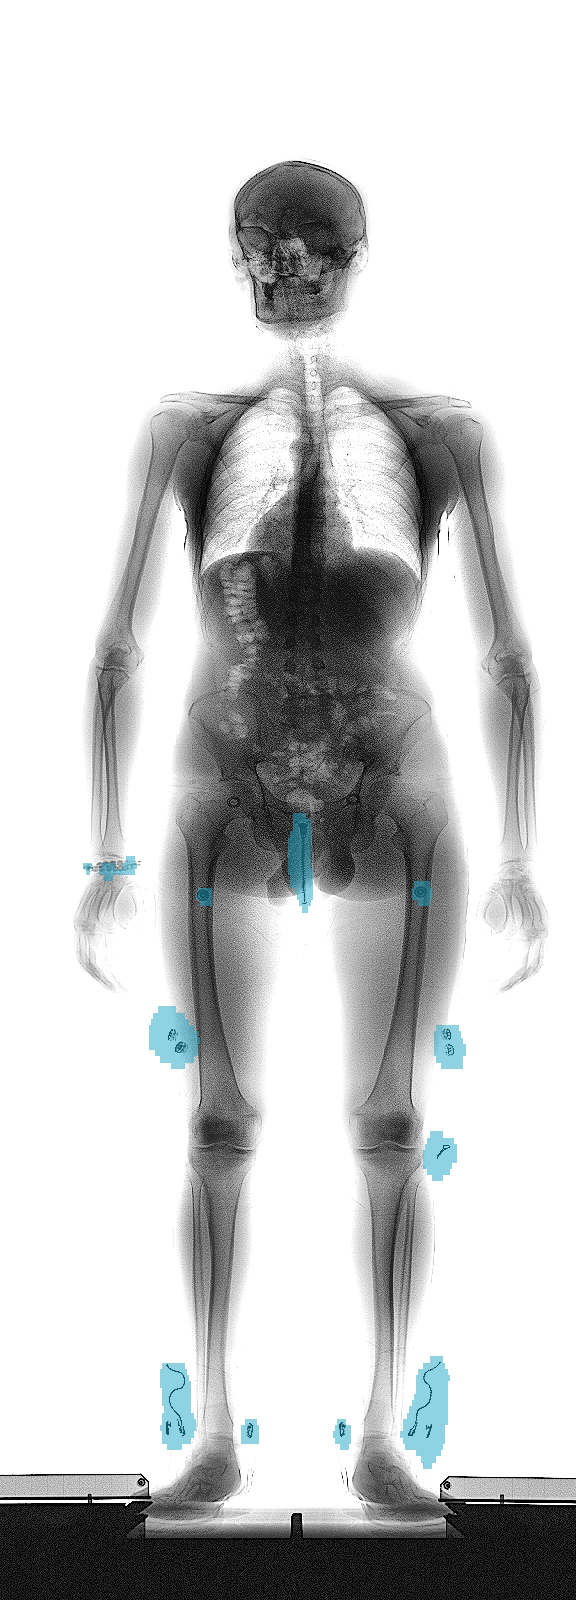

In [445]:
analyze(data)[0] #.save("example_4.png")

In [11]:
device = torch.device('cpu')
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH, map_location=device))

model.load_state_dict(torch.load("transunet_80epo_bce_vit8.meow", map_location=device))

<All keys matched successfully>

In [184]:
from torchvision.utils import draw_segmentation_masks as dsm

In [333]:
def g_to_rgb(image):
        """ Convert grayscale to rgb image
        (add two identical channels)
        """
        return np.stack([image, image, image], axis=1)

In [215]:
g_to_rgb(torch.from_numpy(show(t_images))).shape, torch.from_numpy(show(t_output)).unsqueeze(0).shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

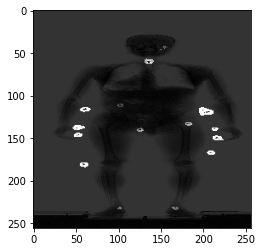

In [236]:
plt.imshow(einops.rearrange(r, "c h w -> h w c"))

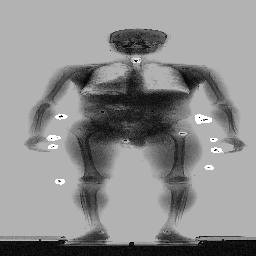

In [243]:
img = g_to_rgb(torch.from_numpy(show(t_images)))
msk = torch.from_numpy(show(t_output)) == 255

r = dsm(image=img, masks=msk, alpha=0.3).numpy()
r = einops.rearrange(r, "c h w -> h w c")
rr = Image.fromarray(r)
rr = rr.convert('RGB')
rr

>> torch.Size([1600, 576])


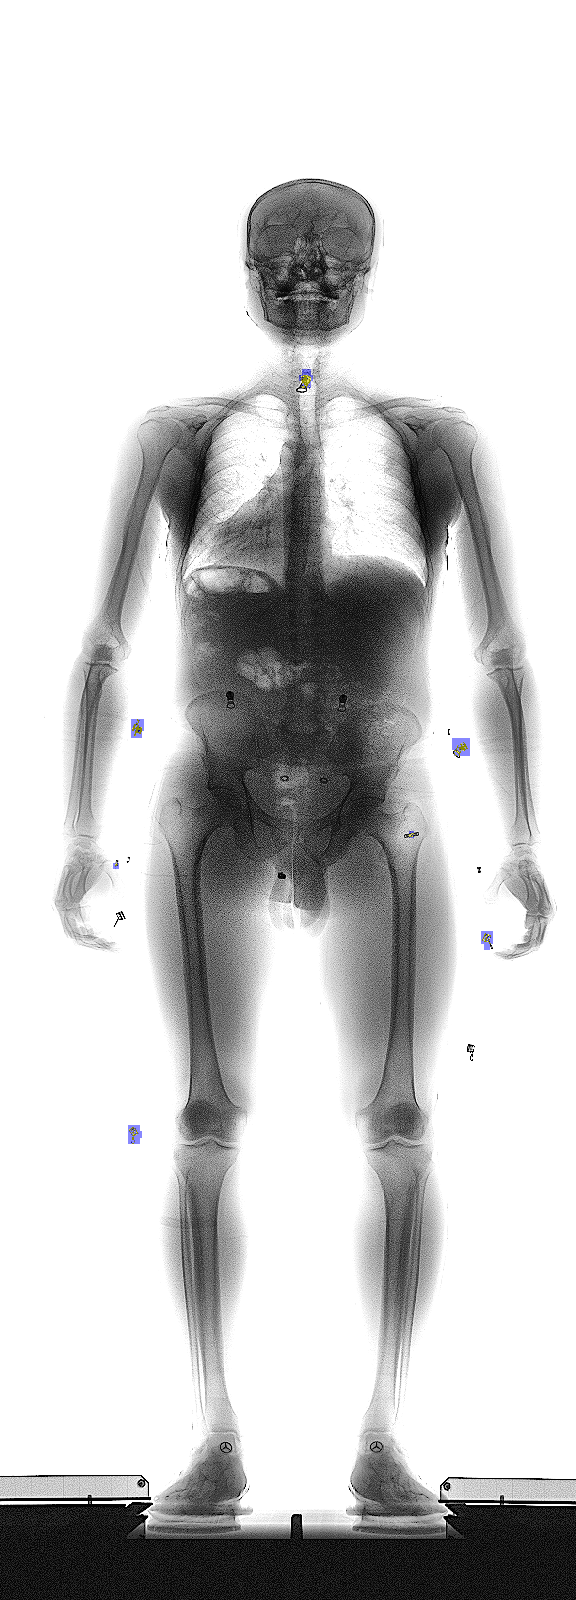

In [182]:
analyze(data)[0] #.save("presentation2.png")
# analyze(data).save("res70_wow.png")

In [69]:
me = "/home/student/Downloads/me5.png"
girl = "/home/student/Downloads/girl5.png"
giant = "/home/student/Downloads/giant5.png"

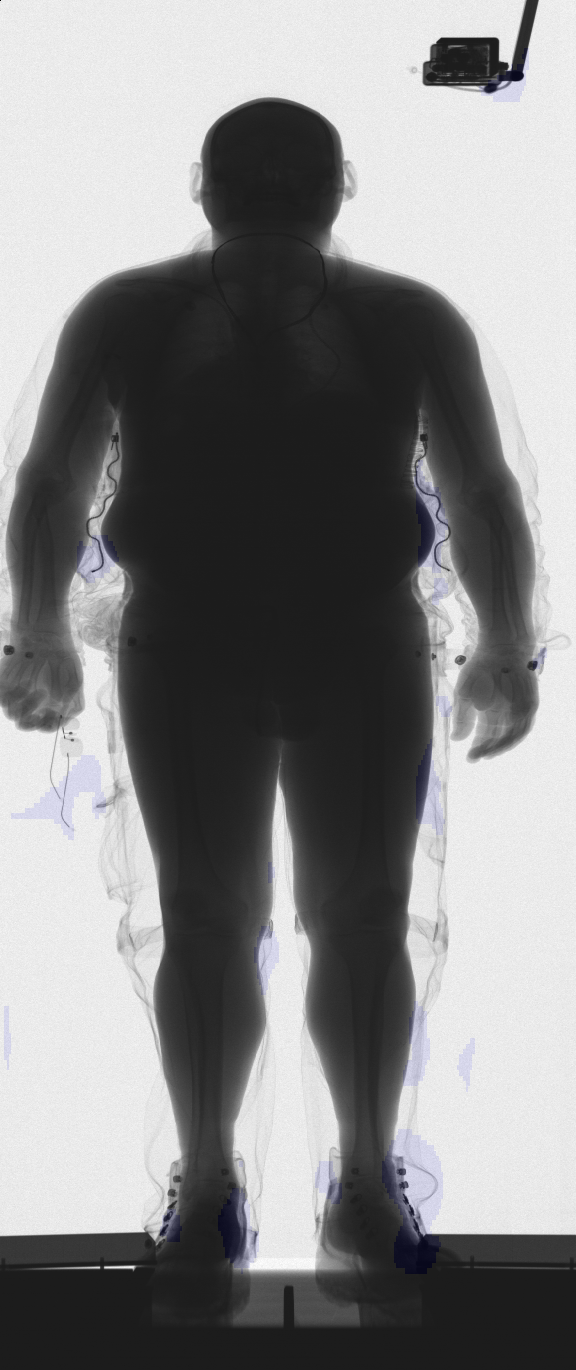

In [437]:
Image.fromarray(
    intensity(
        (MinMaxNormalize()(np.array(Image.open(giant))) * 255).astype(np.uint8),
        np.array(me_output_mask), (20, 20, 0)
    )
)

In [427]:
Image.fromarray(
    intensity(np.array(Image.open(giant)), np.array(me_output_mask), 20).astype(np.uint16)
)

TypeError: Cannot handle this data type: (1, 1, 3), <u2

In [409]:
Image.open(giant).size

(576, 1370)

In [384]:
me_arr

tensor([[[[ 66.6381,  66.7824,  66.7741,  ...,  66.9163,  66.8326,  66.9142],
          [-16.0209, -14.5816, -15.5502,  ..., -15.7782, -15.6318, -15.1799],
          [-16.0753, -13.2782, -15.9247,  ..., -14.9351, -13.5146, -14.1109],
          ...,
          [ 67.4561,  67.3640,  67.3828,  ...,  67.5021,  67.5063,  67.5042],
          [ 67.4226,  67.4707,  67.4728,  ...,  67.4791,  67.5251,  67.5063],
          [ 67.5042,  67.4874,  67.4582,  ...,  67.5084,  67.5042,  67.5146]]]])

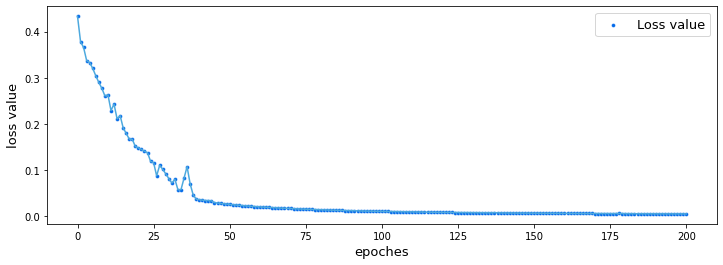

In [366]:
plt.figure(figsize=(12, 4))
sns.scatterplot(x=range(len(losses)), y=losses, color="#036aea", s=15, label="Loss value", marker="o")
sns.lineplot(x=range(len(losses)), y=losses, color="#4da9de")
plt.legend(prop={'size': 13})
plt.xlabel("epoches", fontsize=13)
plt.ylabel("loss value", fontsize=13)
# plt.show()
plt.savefig("losses.jpg")

In [355]:
plt.xlabel?

Signature: plt.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)
Docstring:
Set the label for the x-axis.

Parameters
----------
xlabel : str
    The label text.

labelpad : float, default: :rc:`axes.labelpad`
    Spacing in points from the Axes bounding box including ticks
    and tick labels.  If None, the previous value is left as is.

loc : {'left', 'center', 'right'}, default: :rc:`xaxis.labellocation`
    The label position. This is a high-level alternative for passing
    parameters *x* and *horizontalalignment*.

Other Parameters
----------------
**kwargs : `.Text` properties
    `.Text` properties control the appearance of the label.

See Also
--------
text : Documents the properties supported by `.Text`.
File:      /usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py
Type:      function


In [26]:
torch.randint(0, 2, (10, 1))

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0]])